In [1]:
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import hub
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchaudio

import numpy as np
import pandas as pd

from sklearn.metrics import f1_score, recall_score, precision_score, balanced_accuracy_score, accuracy_score, classification_report
from sklearn.utils import shuffle

import scipy

from tqdm import tqdm

from datasets import load_dataset, Dataset, Audio
import librosa

from models.swishnet import SwishNet

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
AUDIO_LENGTH = 6_000
SEQUENCE_LENGTH = 31
MFCC = 128
print(f"It's {DEVICE} time!!!")

It's cuda time!!!


In [3]:
DATA_DIR = os.path.join('..', 'data')
VOICES_DIR = os.path.join(DATA_DIR, 'Voices_wav')
APHASIA_DIR = os.path.join(VOICES_DIR, 'Aphasia')
NORM_DIR = os.path.join(VOICES_DIR, 'Norm')
train_data = pd.read_csv(os.path.join(DATA_DIR, 'train_filenames.csv'))
val_data = pd.read_csv(os.path.join(DATA_DIR, 'val_filenames.csv'))
test_data = pd.read_csv(os.path.join(DATA_DIR, 'test_filenames.csv'))

train_data = shuffle(train_data).reset_index(drop=True)
val_data = shuffle(val_data).reset_index(drop=True)
test_data = shuffle(test_data).reset_index(drop=True)
train_dataset = Dataset.from_pandas(train_data)
train_dataset = train_dataset.class_encode_column("label")

val_dataset = Dataset.from_pandas(val_data)
val_dataset = val_dataset.class_encode_column("label")

test_dataset = Dataset.from_pandas(test_data)
test_dataset = test_dataset.class_encode_column("label")


def convert_to_path(example):
    if example["label"] == 0:
        example['signal'] = os.path.join(NORM_DIR, example["file_name"])
    elif example["label"] == 1:
        example['signal'] = os.path.join(APHASIA_DIR, example["file_name"])
    return example


train_dataset = train_dataset.map(convert_to_path).cast_column("signal", Audio(sampling_rate=8_000))
val_dataset = val_dataset.map(convert_to_path).cast_column("signal", Audio(sampling_rate=8_000))
test_dataset = test_dataset.map(convert_to_path).cast_column("signal", Audio(sampling_rate=8_000))

Stringifying the column:   0%|          | 0/472 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/472 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/159 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/159 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/172 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/172 [00:00<?, ? examples/s]

Map:   0%|          | 0/472 [00:00<?, ? examples/s]

Map:   0%|          | 0/159 [00:00<?, ? examples/s]

Map:   0%|          | 0/172 [00:00<?, ? examples/s]

In [4]:
mfcc_class = torchaudio.transforms.MFCC(sample_rate=8_000, n_mfcc=MFCC, log_mels=True, melkwargs={"n_fft": 600, "win_length": 400, "hop_length": 200, "n_mels": 200})

def preprocess_function_mfcc(examples):
    audio_arrays = []
    for x in examples:
        seq = torch.Tensor(x["array"][..., :AUDIO_LENGTH])
        seq = nn.functional.pad(seq, (0, AUDIO_LENGTH - seq.shape[-1]), mode="constant")
        mfcc = mfcc_class(seq)
        # print(mfcc.shape)
        
        # mfcc = nn.functional.pad(mfcc, (0, SEQUENCE_LENGTH - mfcc.shape[-1]), mode="constant")
        mfcc[..., 0, :], mfcc[..., 1, :] = mfcc[..., 1, :], mfcc[..., 0, :]
        audio_arrays.append(mfcc.numpy())
    return torch.Tensor(audio_arrays)

In [5]:
from collections import Counter

class_counts = Counter(train_data["label"])


class_weights = {label: 1.0 / count for label, count in class_counts.items()}
weights = [class_weights[label] for label in train_data["label"]]

In [6]:
SEED = 1984

np.random.seed(SEED)
torch.manual_seed(SEED)

gen = torch.Generator()
gen.manual_seed(SEED)

def split_into_windows(signal, window_size=20 * 8000, step=20 * 8000):
    return [signal[i : i + window_size] for i in range(0, len(signal) - window_size + 1, step)]


def collate_batch(batch):
    time_series = list(map(lambda item: item["signal"], batch))
    target = list(map(lambda item: item['label'], batch))
    
    return time_series, torch.tensor(target)

def step_scheduler(optimizer, step_size):
    # warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=start_factor, end_factor=1.0, total_iters=warmup_dur)
    # cos_annealing = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)
    # warnup_then_cos_anneal = torch.optim.lr_scheduler.SequentialLR(optimizer, [warmup, cos_annealing], milestones=[warmup_dur])
    step_lr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)
    return step_lr

def train_model(model, dataset_train, dataset_val, epochs=1, lr=0.001, device="cpu"):
      
    model = model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    train_sampler = WeightedRandomSampler(weights, num_samples=len(train_dataset), replacement=True)
    
    dl_train = DataLoader(dataset_train, batch_size=32, shuffle=False, drop_last=True, sampler=train_sampler, collate_fn=collate_batch, generator=gen, num_workers=4)
    dl_val = DataLoader(dataset_val, batch_size=32, shuffle=False, drop_last=True, collate_fn=collate_batch, generator=gen, num_workers=4)
    
    scheduler = step_scheduler(optimizer, 20) 
        
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    for epoch in tqdm(range(epochs), desc="Training model"):
        model.train()
        total_train_loss = 0
        total_val_loss = 0
        
        train_acc = []
        val_acc = []
        for ts, target in dl_train:
            ts = preprocess_function_mfcc(ts)
            ts, target = ts.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(ts)
            

            preds = torch.argmax(output.squeeze(), dim=1).cpu().detach().numpy()

            train_acc.append(accuracy_score(target.cpu().detach().numpy(), preds))

            loss = criterion(output.squeeze(), target)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.detach().item()
        scheduler.step(epoch=epoch)
        
        avg_train_acc = np.stack(train_acc, axis=0).mean()

        avg_train_loss = total_train_loss / len(dataset_train)
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
                
        model.eval()
        
        with torch.no_grad():
            for ts, target in dl_val:
                ts = preprocess_function_mfcc(ts)
                # ts = ts.permute(0, 2, 1)
                ts, target = ts.to(device), target.to(device)
                
                output = model(ts)
                
                preds = torch.argmax(output, dim=1).cpu().detach().numpy()
                val_acc.append(accuracy_score(target.cpu().detach().numpy(), preds))
                loss = criterion(output.squeeze(), target)
                total_val_loss += loss.detach().item()
        
        avg_val_acc = np.stack(val_acc, axis=0).mean()
        avg_val_loss = total_val_loss / len(dataset_val)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)
        
        if epoch % 10 == 0:
            tqdm.write(f"Epoch {epoch}: train loss: {avg_train_loss:.3f}, train balanced acc: {avg_train_acc:.2f}, test loss: {avg_val_loss:.3f}, test balanced acc: {avg_val_acc:.2f}, lr: {optimizer.param_groups[0]['lr']}")

            
    return model, train_loss_list, val_loss_list, train_acc_list, val_acc_list

In [7]:
swishnet = SwishNet(MFCC, 2, input_size=SEQUENCE_LENGTH, dropout_rate=0.5)

In [8]:
swishnet, train_l, val_l, train_accuracy, val_accuracy = train_model(swishnet, train_dataset, val_dataset, epochs=20, lr=1e-4, device=DEVICE)

Training model:   5%|▌         | 1/20 [00:05<01:53,  5.98s/it]

Epoch 0: train loss: 0.020, train balanced acc: 0.56, test loss: 0.018, test balanced acc: 0.26, lr: 0.0001


Training model:  55%|█████▌    | 11/20 [01:00<00:49,  5.47s/it]

Epoch 10: train loss: 0.020, train balanced acc: 0.71, test loss: 0.017, test balanced acc: 0.68, lr: 0.0001


Training model: 100%|██████████| 20/20 [01:50<00:00,  5.53s/it]


In [9]:
def test_model(model, test_data):
    model = model.to("cpu")
        
    model.eval()
    preds = []
    with torch.no_grad():
        for sgnl, target in zip(test_data["signal"], test_data["label"]):
            sgnl = preprocess_function_mfcc([sgnl])

            label = model(sgnl).to("cpu").detach().numpy().squeeze()
            preds.append(label.argmax(axis=-1))
    preds = np.array(preds)
    
    print(classification_report(test_data["label"], preds))
    return preds

In [10]:
test_model(swishnet, test_dataset)

              precision    recall  f1-score   support

           0       0.48      0.81      0.60        42
           1       0.92      0.72      0.81       130

    accuracy                           0.74       172
   macro avg       0.70      0.76      0.70       172
weighted avg       0.81      0.74      0.76       172



array([0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0])

Text(0.5, 0, 'Epoch')

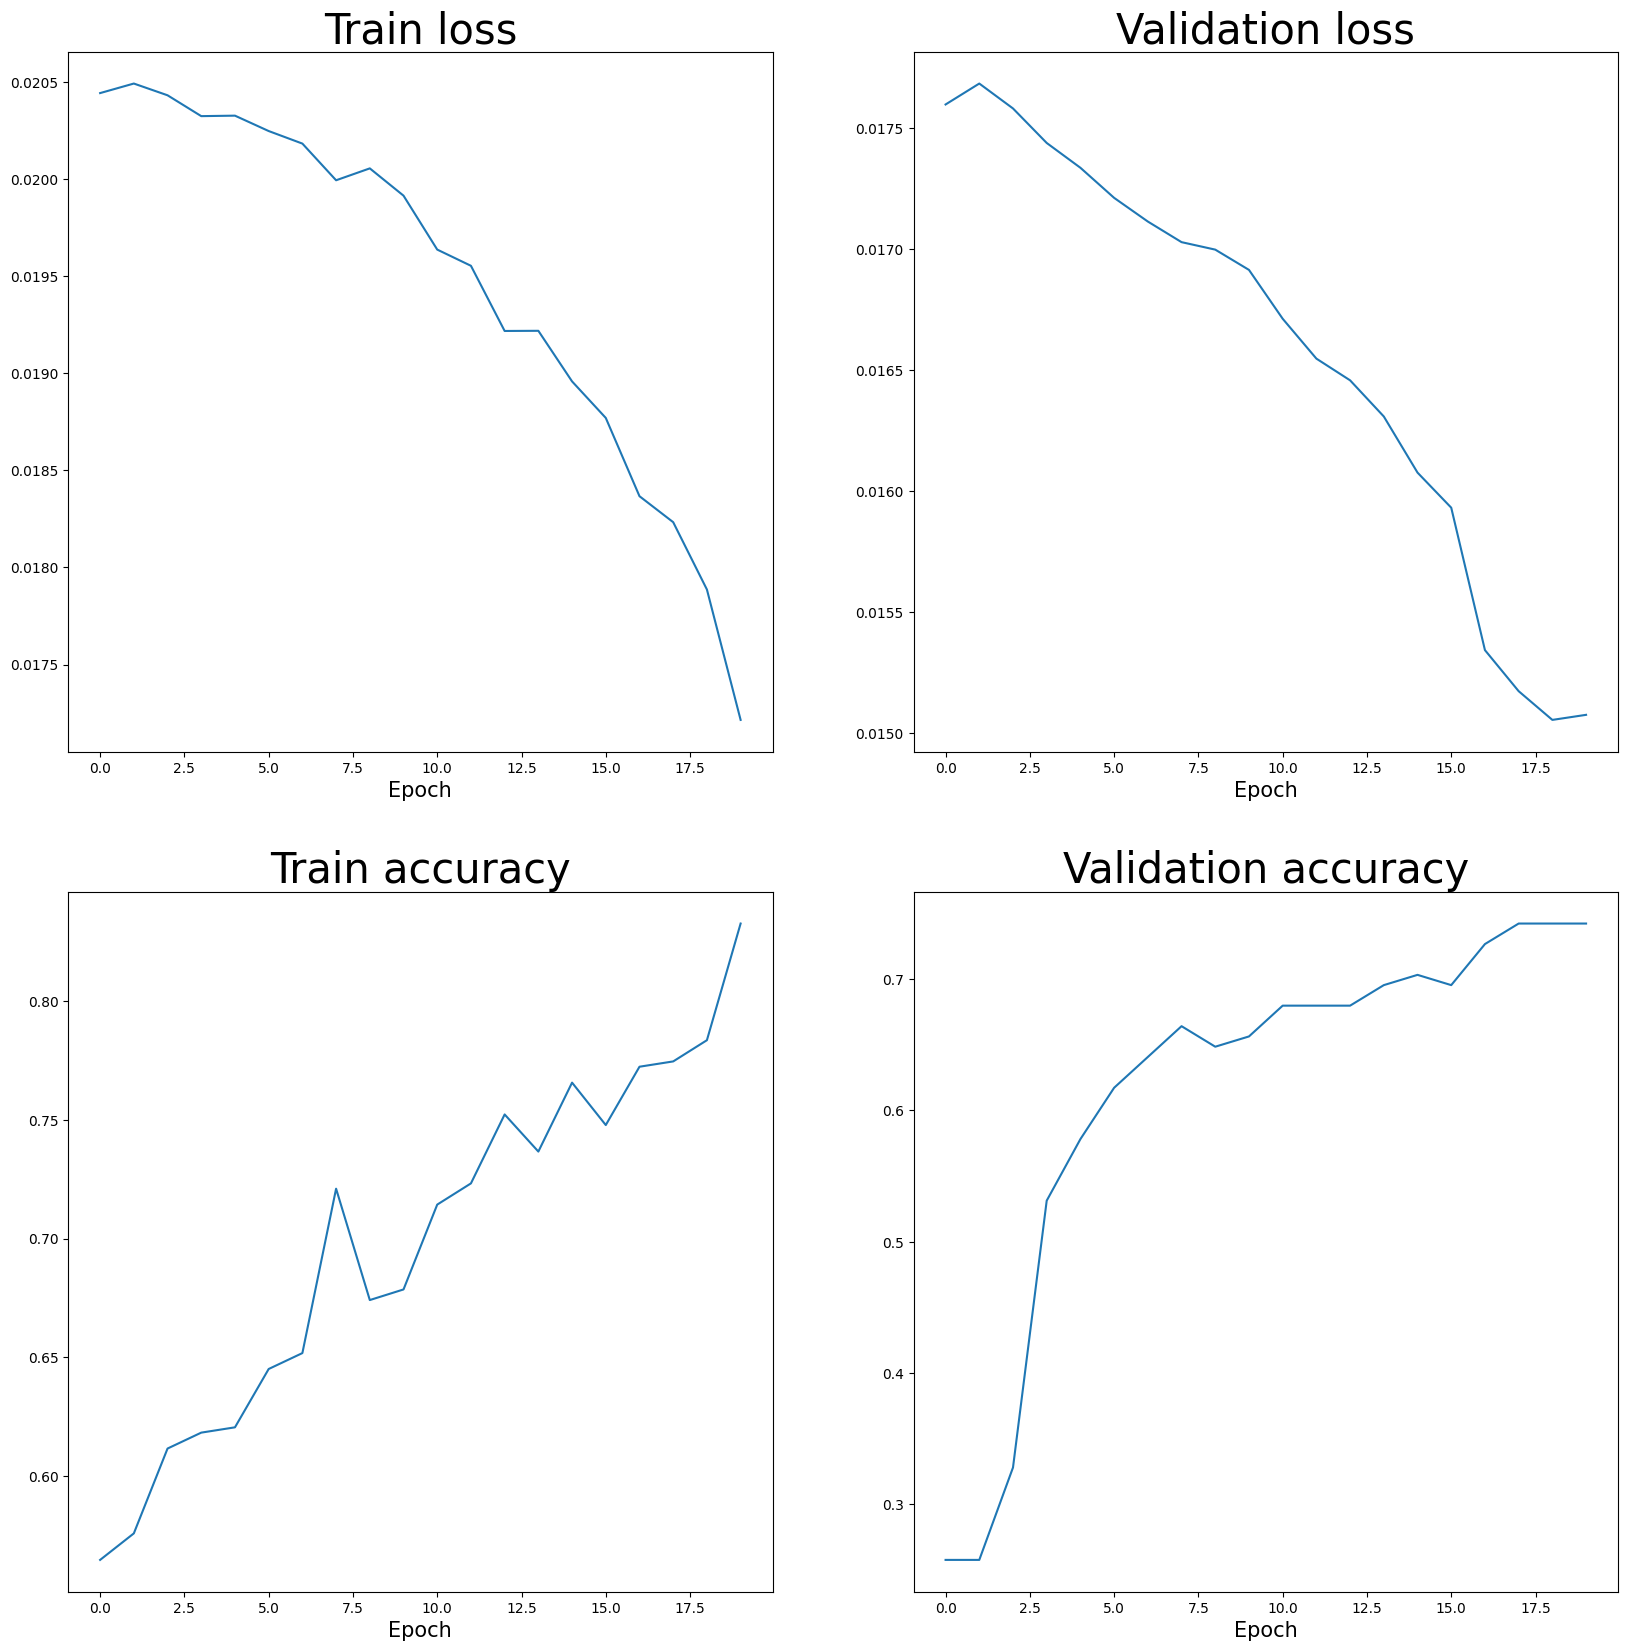

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

axes[0][0].plot(train_l)
axes[0][0].set_title("Train loss", fontsize=30)
axes[0][0].set_xlabel("Epoch", fontsize=15)

axes[0][1].plot(val_l)
axes[0][1].set_title("Validation loss", fontsize=30)
axes[0][1].set_xlabel("Epoch", fontsize=15)

axes[1][0].plot(train_accuracy)
axes[1][0].set_title("Train accuracy", fontsize=30)
axes[1][0].set_xlabel("Epoch", fontsize=15)

axes[1][1].plot(val_accuracy)
axes[1][1].set_title("Validation accuracy", fontsize=30)
axes[1][1].set_xlabel("Epoch", fontsize=15)

In [12]:
def test_model(model, test_data):
    model = model.to("cpu")
        
    model.eval()

    test_data["ID"] = test_data["file_name"].apply(
        lambda x: str(x).split("-")[0] + str(x).split("-")[1])
    test_data.head()
    IDs = test_data["ID"].unique()

    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for participant_id in tqdm(IDs):
            participant_samples = test_data[test_data["ID"] == participant_id]
            sgnls = []
            for ind, participant_sample in participant_samples.iterrows():

                sgnl_path = participant_sample["file_name"]

                if participant_sample['label'] == 0:
                    sgnl_path = os.path.join(NORM_DIR, sgnl_path)
                else:
                    sgnl_path = os.path.join(APHASIA_DIR, sgnl_path)
                    
                y, sr = librosa.load(sgnl_path, sr=8_000)
                y = preprocess_function_mfcc([{"array": y}]).squeeze()
                sgnls.append(y)
                # print(y.shape)
                
            labels = participant_samples["label"]
  
            sgnls = torch.from_numpy(np.array(sgnls))
            preds = model(sgnls).detach().numpy().squeeze().argmax(axis=-1)
            pred = scipy.stats.mode(preds)

            all_preds.append(pred.mode)
        
            all_labels.append(labels.values[0])
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    print(classification_report(all_labels, all_preds))
    
    return all_preds

In [13]:
test_data = pd.read_csv(os.path.join(DATA_DIR, 'test_filenames.csv'))

### Метрики с агрегацией по записям для каждого испытуемого

In [14]:
test_model(swishnet, test_data)

100%|██████████| 72/72 [00:01<00:00, 38.09it/s]

              precision    recall  f1-score   support

           0       0.56      0.95      0.70        21
           1       0.97      0.69      0.80        51

    accuracy                           0.76        72
   macro avg       0.76      0.82      0.75        72
weighted avg       0.85      0.76      0.77        72



array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1])

In [15]:
total_params = sum(p.numel() for p in swishnet.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 24745


In [16]:
torch.save(swishnet.state_dict(), os.path.join('..', 'pretrained_models', 'swishnet_model.pt'))